## Leaky integrated firing neuron model  
## Few feautures :
### Spatial network, no memory term but exponential decay of cumulative dose

This is a minor change of the Dodds and Watts model  
Implement adaptive rewiring and generate statistics

In [66]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
# from numba import jit #numba precomplier to make the code faster
import pandas as pd
import copy

# Variables used in the simulation

In [67]:
N = 100
gamma = 1 #decay of cumulative dose per unit time (second)
T = 100 #total number of seconds
dt = 0.05 #seconds
'''number of simulation steps is T/dt'''

'''Dodds watts parameters'''
p = 1 #rate of dose transfer (per unit time (second))
p = p*dt #rate of dose transfer per unit simulation step
r = 1/dt
r = r*dt
rho = 1/dt
rho = rho*dt

d_star = 1
# dose_quantity = 1
D_ini = 3

'''network parameters'''
circ_rad = 100 #for a network in which each node is connected to other nodes withing a circle of radius circ_rad
nn = 7 #the number of nearest neighbours(i.e. k) in knn
average_degree = 6
total_edges = N*6

'''rewiring parameters'''
# p_rew = 5 #rate of rewiring(per unit time(second))
# p_rew = p_rew*dt

'rewiring parameters'

# Creating the network. 
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

In [68]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

### 1. metric network

In [69]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat,circ_rad) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
#     print(type(np.ndarray.tolist(np.transpose(np.where(edge_mask)))))
    return edge_list

### 2. K nearest neighbour network

In [70]:
'''network = knn'''
def knn(dist_mat,nn,N) :
    near_neigh = np.argsort(dist_mat)
    selec_near_neigh = np.zeros((N,nn))
    selec_near_neigh = near_neigh[:,0:nn+1]

    edge_list = []
    for i in range(N) :
        for j in range(1,nn+1) :
            link = [i,selec_near_neigh[i,j]]
            edge_list.append(link)

    return edge_list

### 3. Random Network : GNP type

In [71]:
'''random network'''
def rand_network(average_degree,N) :
    z1 = np.random.uniform(size = (N,N))
    E,F = np.meshgrid(np.arange(0,N),np.arange(0,N))
    mask = ((average_degree/N) > z1) & (E!=F)
    adjacency_matrix = np.int64(np.zeros(shape=(N,N)))
    adjacency_matrix[mask] = np.int64(1)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list,adjacency_matrix

### 4. Random Network : GNM type

In [72]:
def rand_net_gnm(total_edges,N) :
    the_graph = nx.gnm_random_graph(N, total_edges,directed=True)
    adjacency_matrix = nx.adjacency_matrix(the_graph)
    adjacency_matrix = np.asarray(adjacency_matrix.todense())
    np.fill_diagonal(adjacency_matrix,0)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list

# Function defintions required for the main part of the script

In [73]:
# # @jit(nopython=True)
# '''infecting the left part of space.'''
# def left_part_infec(N) :
#     x_coord = []
#     y_coord = []
#     for j in range(len(coords)) :
#         x_coord.append(coords[j][0])
#         y_coord.append(coords[j][1])
#     x_coord = np.asarray(x_coord)
#     y_coord = np.asarray(y_coord)
#     points = np.asarray(np.where(x_coord<(N/5))) 
#     indi_state[points.T] = 2

#     return indi_state

In [74]:
'''infecting connected nodes'''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
            print('Initial node infection step failed')
            return None
    return infected_nodes

In [75]:
''' function to transfer doses'''
# @jit(nopython=True)
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is proabable, dose transfer occurs
    
    return d

In [76]:
'''rewiring function which returns a new adjacency matrix'''

def rew(p_rew,adjacency_matrix,indi_state_for_rew_prev) :
    
    z1_rew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    rew_mask_plus = (p_rew > z1_rew)  & (indi_state_for_rew_prev == 1)
    #create links. Dont break any.
    adjacency_matrix[rew_mask_plus] = 1
    rew_mask_minus = (p_rew > z1_rew) & (indi_state_for_rew_prev == 2)
    #break links. Dont create any.
    adjacency_matrix[rew_mask_minus] = 0
    
    np.fill_diagonal(adjacency_matrix,0)
    return adjacency_matrix

In [ ]:
'''decay function which breaks exisiting links of a node without depending on other nodes'''

def decay(lamb_da,adjacency_matrix) :
    z1_decay = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    decay_mask = (lamb_da > z1_decay) 
    adjacency_matrix[decay_mask] = 0
    
    return adjacency_matrix

In [77]:
'''function to update cumulative doses'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [78]:
'''function to update the states of the nodes of the system'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [79]:
'''function to get/identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

In [80]:
def networkx_graph(coords,edge_list) :
    G = nx.DiGraph()
    pos = {(i): (coords[i][0],coords[i][1]) for i in range(N)}
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge_list)
    return G

In [81]:
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))
    return edge_list

# Choose which network you want in the program
### Coupling network of knn network?

In [82]:
'''returns coordinates, distance matrix, edge_list and the adjacency matrix'''

dist_mat,coords = calc_dist(N) #node placement

# edge_list = coupling(dist_mat,circ_rad)
# edge_list = knn(dist_mat,nn,N)
# edge_list = rand_network(average_degree,N)
edge_list = rand_net_gnm(total_edges,N)

org_adj_mat = np.int64(np.zeros((N,N)))
for i in range(len(edge_list)):
    org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)

# The main part of the script

In [83]:
#infected state time series data frame
#columns indicate the time steps
timeseries_infec_frac = pd.DataFrame()

#in degree as columns and rows as nodes
timeseries_in_degree = pd.DataFrame() 

#out degree as columns and rows as nodes
timeseries_out_degree = pd.DataFrame()

#strongly connected components as columns
timeseries_strong_comps = pd.DataFrame()

#weakly connected components as columns
timeseries_weak_comps = pd.DataFrame()

In [84]:
p_rew_vals = [0.1,1,10]
start_vals = [1,10]
dose_quantity_vals = [0.1,2]

In [85]:
df_row = 0
for p_rew in p_rew_vals : #rate of rewiring (per unit time (second))
    p_rew = p_rew*dt        
    for start in start_vals : #rate of dose transfer (per unit time (second))
        for dose_quantity in dose_quantity_vals : #number of nodes to infect initially
            print('(p_rew,start,dose_quantity) = ', (p_rew/dt,start,dose_quantity))
            
            '''clearing exsiting data frames and creating new ones '''
            timeseries_infec_frac = pd.DataFrame()
            timeseries_in_degree = pd.DataFrame()
            timeseries_out_degree = pd.DataFrame()
            timeseries_strong_comps = pd.DataFrame()
            timeseries_weak_comps = pd.DataFrame()
            
            q = 0 #to generate new edge_list from the new adjacency matrix 
            t = np.arange(0,T,dt)

#             numpy_array = np.zeros((N,len(t)),dtype = np.int64) #stores the states of the nodes. Rows are nodes and columns are time steps
            D_array = np.zeros((N,len(t))) #stores the cumulative doses. Rows are nodes and columns are time steps

            adj_mat_list = []
            adj_mat = org_adj_mat
            adj_mat_new = copy.deepcopy(adj_mat)
            adj_mat_list.append(adj_mat_new) #list of arrays which shows the time series of the adjacency matrix

            #coords remain the same. Get new edge_list from the latest adjacency matrix
            edge_list = edge_from_adj_mat(adj_mat_list,q)
            G = networkx_graph(coords,edge_list) #networkx graph
            
            '''from G, obtain the in degree and the out degree'''
            timeseries_in_degree.loc[:,0] = np.asarray([val for (node, val) in G.in_degree()])
            timeseries_out_degree.loc[:,0] = np.asarray([val for (node, val) in G.out_degree()])
            
            '''strongly and weekely connected components'''
            timeseries_strong_comps.loc[0,0] = nx.number_strongly_connected_components(G)
            timeseries_weak_comps.loc[0,0] = nx.number_weakly_connected_components(G)
            
            '''choosing initially infected nodes'''
            indi_state = np.random.randint(1,2,size=(N,1))
            infected_nodes = None
            while infected_nodes is None : #infecting 'start' number of network neighbours
                infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start)
                print(infected_nodes)
            infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
            indi_state[infected_nodes[:,0],0] = 2

            A,B = np.meshgrid(indi_state,indi_state) 
            partner_state = A
            indi_state_for_rew = B

#             numpy_array [:,0] = indi_state[:,0]

            indi_state_prev = indi_state
            partner_state_prev = partner_state
            indi_state_for_rew_prev = indi_state_for_rew

            d = np.zeros((len(adj_mat),len(adj_mat[0])))

            D = np.zeros((N,1))
            D[np.where(indi_state==2)] = D_ini
            D_array[:,0] = D[:,0]
            D_prev = D

            infec_frac = np.count_nonzero(indi_state == 2)/N
            timeseries_infec_frac.loc[df_row,0] = infec_frac
            '''the main part of the simulation'''
            counter = 0
            df_col = 1
            for t in np.arange(dt,T,dt) :
                q = q + 1 
                counter = counter + 1
                infec_indi = []
                suscep_indi = []
                d = np.zeros((len(adj_mat),len(adj_mat[0])))
                d = dose(adj_mat,p,partner_state_prev,d)

                adj_mat = decay(lamb_da,adj_mat)
                adj_mat = rew(p_rew,adj_mat,indi_state_for_rew_prev)
                adj_mat_new = copy.deepcopy(adj_mat)
                adj_mat_list.append(adj_mat_new)

                #coords remain the same. Get new edge_list from the latest adjacency matrix
                edge_list = edge_from_adj_mat(adj_mat_list,q)
                G = networkx_graph(coords,edge_list) #networkx graph
                
                '''from G, obtain the in degree and the out degree'''
                timeseries_in_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.in_degree()])
                timeseries_out_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.out_degree()])
                
                '''strongly and weekely connected components'''
                timeseries_strong_comps.loc[df_row,df_col] = nx.number_strongly_connected_components(G)
                timeseries_weak_comps.loc[df_row,df_col] = nx.number_weakly_connected_components(G)
                
                D = cumu_dose(d,D_prev,gamma)
                D_array[:,counter] = D[:,0]

                indi_state = upd_indi_state(D,d_star,indi_state_prev)
                infec_frac = np.count_nonzero(indi_state == 2)/N
                timeseries_infec_frac.loc[df_row,df_col] = infec_frac

#                 numpy_array[:,counter] = indi_state[:,0]
                A,B = np.meshgrid(indi_state,indi_state)

                infec_indi, suscep_indi = states(indi_state)

                partner_state = A
                indi_state_for_rew = B
                indi_state_prev = indi_state
                partner_state_prev = partner_state
                indi_state_for_rew_prev = indi_state_for_rew

                D_prev = D
                D = np.zeros((N,1))
                df_col = df_col + 1 

#             df_row = df_row + 1 #going to the next row of the df to store timeseries of next (p,start)

            filename_infec_frac = 'infec_frac.h5'
            filename_in_deg = 'in_deg.h5'
            filename_out_deg = 'out_deg.h5'
            filename_strong_comps = 'strong_comps.h5'
            filename_weak_comps = 'weak_comps.h5'
            key_val = 'p_rew_'+str(np.int64(p_rew/dt))+'_start_'+str(start)+'_dq_'+str(np.int64(dose_quantity*10))
            timeseries_infec_frac.to_hdf(filename_infec_frac, key = key_val, mode='a')
            timeseries_in_degree.to_hdf(filename_in_deg, key = key_val, mode='a')
            timeseries_out_degree.to_hdf(filename_out_deg, key = key_val, mode='a')
            timeseries_strong_comps.to_hdf(filename_strong_comps, key = key_val, mode='a')
            timeseries_weak_comps.to_hdf(filename_weak_comps, key = key_val, mode='a')
            df_row = 0

(p_rew,start,dose_quantity) =  (0.10000000000000002, 1, 0.1)
{94}
(p_rew,start,dose_quantity) =  (0.10000000000000002, 1, 2)
{9}
(p_rew,start,dose_quantity) =  (0.10000000000000002, 10, 0.1)
{32, 72, 10, 47, 20, 53, 87, 88, 56, 27}
(p_rew,start,dose_quantity) =  (0.10000000000000002, 10, 2)
{65, 2, 3, 1, 74, 14, 51, 58, 30, 63}
(p_rew,start,dose_quantity) =  (1.0, 1, 0.1)
{57}
(p_rew,start,dose_quantity) =  (1.0, 1, 2)
{79}
(p_rew,start,dose_quantity) =  (1.0, 10, 0.1)
Initial node infection step failed
None
{33, 1, 73, 44, 15, 18, 83, 50, 88, 59}
(p_rew,start,dose_quantity) =  (1.0, 10, 2)
{37, 7, 41, 77, 50, 86, 88, 89, 93, 30}
(p_rew,start,dose_quantity) =  (10.0, 1, 0.1)
{53}
(p_rew,start,dose_quantity) =  (10.0, 1, 2)
{33}
(p_rew,start,dose_quantity) =  (10.0, 10, 0.1)
Initial node infection step failed
None
Initial node infection step failed
None
{97, 68, 72, 43, 46, 20, 22, 57, 60, 94}
(p_rew,start,dose_quantity) =  (10.0, 10, 2)
{0, 64, 34, 74, 81, 49, 51, 19, 57, 29}


In [86]:
# '''time series plot of a fixed start but varying p'''
# a = 4 #this is the value of p-1
# for i in np.arange(0,110,10) : 
#     print(a+i)
#     timeseries_infec_frac.loc[a+i,:].plot()
# plt.ylim(-0.1,1.1)
# # plt.xlim(0,10)
# plt.legend(loc=(1,1))
# plt.show()

In [87]:
# plt.clf()
# '''time series plot of a fixed p but varying start'''
# a = 40 # this is the value of p
# for i in range(0,11) :
#     timeseries_infec_frac.loc[a+i,:].plot()
# plt.ylim(-0.1,1.1)
# # plt.ylim(-0.01,0.11)
# # plt.xlim(0,2.5)
# plt.legend(loc=(1,1))
# plt.show()

In [88]:
# start_len = 10
# p_len = 11
# X,Y = np.meshgrid([i*0.01 for i in range(11,21)],[i*0.1 for i in range(0,11)])
# print('X = ', X)
# print('Y = ', Y)
# phi = 999*np.ones((p_len,start_len))
# counter = 0
# last_col = np.int64((T/dt)-1)
# for i in range(p_len) :
#     for j in range(start_len) :
#         phi[i,j] = timeseries_infec_frac.loc[counter,(last_col-100)+1:last_col].mean()
#         counter = counter + 1
# # print(counter)
# print(phi)
# fig = plt.gcf()
# fig.set_size_inches(10, 9)
# plt.scatter(X, Y,s=500,c=phi,vmin=0,vmax=1)
# plt.colorbar()
# plt.xlabel(r'$\phi_{ini}$', fontsize = 20)
# plt.ylabel(r'$p\times dt$', fontsize = 20)
# plt.xlim(0.10,0.21)
# plt.title(r'$\phi^*,p_{rew}=0.5,av_{deg}=9,d=1,d^*=3,\gamma=5,T=N=100,dt=0.1,r=1$',fontsize = 15)
# plt.savefig('static_avdeg_9_ini_0_11.svg',format='svg')
# plt.show()

In [89]:
# filename = 'file_avdeg_'+str(average_degree)+'_ini_'+str(np.int64(X[0,0]*N))+'_'+str(np.int64(X[p_len-1,start_len-1]*N))+'.h5'
# key 
# timeseries_infec_frac.to_hdf(filename, key='timeseries_infec_frac', mode='w')

In [90]:
# import h5py
# f = h5py.File('file_avdeg_6_ini_0_11.h5', 'r')
# [key for key in f.keys()]
# pd.read_hdf('file_avdeg_6_ini_0_11_firstattemp.h5','p_rew_2')

   0
0  0
1  1
2  2
3  1
4  1
5  1


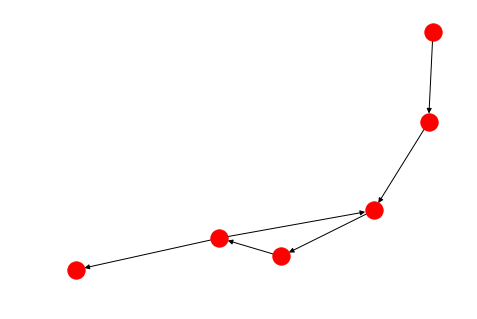

In [91]:
timeseries= pd.DataFrame()
G = nx.DiGraph()
G.add_nodes_from(range(5))
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,5),(4,2)])
nx.draw(G)
# nx.number_weakly_connected_components(G)
la = np.asarray([val for (node, val) in G.in_degree()])
timeseries.loc[:,0] = la
print(timeseries)